# 0. 가위바위보 분류기를 만들자

가위바위보 이미지를 분류하는 모델을 만들어보자.

## 0.1. 라이브러리 불러오기

In [120]:
import os

import glob
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

tensorflow를 사용하려면 가상환경을 활성화해야 한다.

# 1. 데이터를 준비하자

## 1.1. 데이터 만들기

직접 가위바위보 이미지를 만들어보자.  
스마트폰의 연속 촬영을 이용하거나 노트북의 웹캠을 이용하여  
Teachable Machine 사이트에서 연속 촬영을 할 수 있다.  
https://teachablemachine.withgoogle.com/  
(시작하기 -> 이미지 프로젝트 -> 표준 이미지 모델)

다양한 각도, 다양한 크기로 찍는 것이 좋다.

필자는 train 데이터로 가위바위보 각 500장 = 1500장의 사진이 담긴  
https://drive.google.com/drive/folders/1qhk6LUzQgrZD_whH2RhzbMy0SQDDrFmK  

test 데이터로 가위바위보 각 200장 = 600장의 사진이 담긴  
https://drive.google.com/drive/folders/1_o1GyWOBRjWfdGneBMYTCZEp992ye9Kt  
데이터를 사용했다.

## 1.2. Resize 하기

모델이 너무 쉽게 학습되면 재미없으므로 MNIST의 이미지 사이즈 28 x 28로 resize 해서 모델을 학습시켜보자.

In [121]:
def resize_images(img_path):
    images = glob.glob(img_path + "\*.jpg") # 이미지들 저장
    print(len(images), "images to be resized.")
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    
    for img in images:
        old_img = Image.open(img) # 이미지를 열고
        new_img = old_img.resize(target_size, Image.ANTIALIAS) # 사이즈를 바꾼 후
        new_img.save(img, "JPEG") # 리사이즈된 사진으로 바꿔 저장
    
    print(len(images), "images resized.")

In [122]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일 읽기
paper_path = os.getenv("USERPROFILE") + "\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\\5\data\paper"
resize_images(paper_path)

500 images to be resized.


C:\Users\Hugh\AppData\Local\Temp\ipykernel_8156\281429368.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS) # 사이즈를 바꾼 후


500 images resized.


In [123]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일 읽기

scissor_path = os.getenv("USERPROFILE") + "\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\\5\data\scissor"
resize_images(scissor_path)

500 images to be resized.


C:\Users\Hugh\AppData\Local\Temp\ipykernel_8156\281429368.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS) # 사이즈를 바꾼 후


500 images resized.


In [124]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일 읽기
rock_path = os.getenv("USERPROFILE") + "\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\\5\data\\rock"
resize_images(rock_path)

500 images to be resized.


C:\Users\Hugh\AppData\Local\Temp\ipykernel_8156\281429368.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS) # 사이즈를 바꾼 후


500 images resized.


## 1.3. 데이터 불러오기

In [125]:
def load_data(img_path, number_of_data=None):
    '''
    이미지를 행렬로 변환하고 label도 생성하는 함수.
    가위바위보 이미지 개수 총합에 주의하세요.
    보 : 0, 가위 : 1, 바위 : 2
    '''
    img_size = 28
    color = 3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)
    idx = 0
    
    for img in glob.iglob(img_path + '\paper\*.jpg'):
        img = np.array(Image.open(img), dtype=np.int32)
        imgs[idx, :, :, :] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 보 : 0
        idx = idx + 1

    for img in glob.iglob(img_path + '\scissor\*.jpg'):
        img = np.array(Image.open(img), dtype=np.int32)
        imgs[idx, :, :, :] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 가위 : 1
        idx = idx + 1
    
    for img in glob.iglob(img_path + '\\rock\*.jpg'):
        img = np.array(Image.open(img), dtype=np.int32)
        imgs[idx, :, :, :] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 바위 : 2
        idx = idx + 1
        
    print("데이터의 이미지 개수는", idx, "입니다.")
    
    return imgs, labels

In [126]:
train_path = os.getenv("USERPROFILE") + "\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\\5\data"
train_X, train_y = load_data(train_path, number_of_data=1500)

train_X = train_X / 255.0   # 입력은 0~1 사이의 값으로 정규화

print("train_X shape: {}".format(train_X.shape))
print("train_y shape: {}".format(train_y.shape))

데이터의 이미지 개수는 1500 입니다.
train_X shape: (1500, 28, 28, 3)
train_y shape: (1500,)


In [127]:
test_path = os.getenv("USERPROFILE") + "\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\\5\data\\test"
test_X, test_y = load_data(test_path, number_of_data=600)

test_X = test_X / 255.0   # 입력은 0~1 사이의 값으로 정규화

print("test_X shape: {}".format(test_X.shape))
print("test_y shape: {}".format(test_y.shape))

데이터의 이미지 개수는 600 입니다.
test_X shape: (600, 28, 28, 3)
test_y shape: (600,)


Category:  0


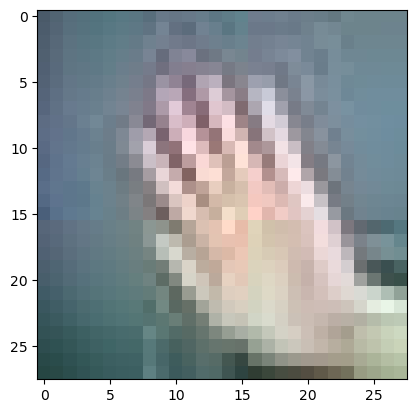

In [128]:
plt.imshow(train_X[0])
print('Category: ', train_y[0])

Category:  0


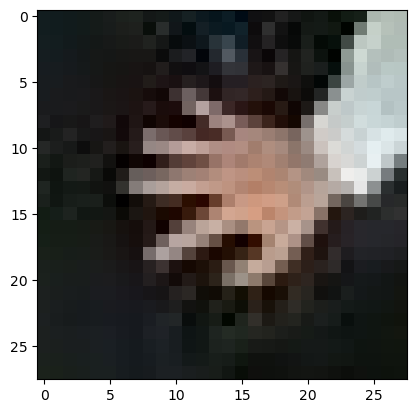

In [129]:
plt.imshow(test_X[0])
print('Category: ', test_y[0])

# 2. 딥러닝 네트워크 설계하기

In [301]:
model = keras.models.Sequential() # Sequential Model 인스턴스 생성. 이름에서 알 수 있듯이 층을 하나씩 쌓아갈 수 있다.
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3))) # first Convolution 층
model.add(keras.layers.MaxPool2D(2, 2)) # first MaxPooling 층

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu')) # second Convolution 층
model.add(keras.layers.MaxPool2D(2, 2)) # second MaxPooling 층

model.add(keras.layers.Flatten()) # 벡터로 변환
model.add(keras.layers.Dense(32, activation='relu')) # 차원 축소 혹은 확장 층

model.add(keras.layers.Dense(3, activation='softmax')) # 최종 출력 층. 3개의 값 중 가장 높은 값이 예측값이 된다.

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_141 (Conv2D)         (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_140 (MaxPooli  (None, 13, 13, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_142 (Conv2D)         (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_141 (MaxPooli  (None, 5, 5, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_69 (Flatten)        (None, 800)               0         
                                                                 
 dense_138 (Dense)           

# 3. 딥러닝 네트워크 학습시키기

In [302]:
# label이 label incoding 형식이므로 loss = sparse_categorical_crossentropy를 줘야하고, 정확도도 Epoch마다 살펴보도록 하자.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, epochs=10)

Epoch 1/10
47/47 [==============================] - 1s 6ms/step - loss: 0.9482 - accuracy: 0.6367
Epoch 2/10
47/47 [==============================] - 0s 5ms/step - loss: 0.4277 - accuracy: 0.9040
Epoch 3/10
47/47 [==============================] - 0s 8ms/step - loss: 0.1669 - accuracy: 0.9687
Epoch 4/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0697 - accuracy: 0.9920
Epoch 5/10
47/47 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.9953
Epoch 6/10
47/47 [==============================] - 0s 7ms/step - loss: 0.0233 - accuracy: 0.9993
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 9/10
47/47 [==============================] - 0s 10ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 0s 10ms/step - loss: 0.0054 - accuracy: 1.0000


# 4. 얼마나 잘 만들었는지 확인하기

In [303]:
# crossentropy 값과 정확도를 살펴보자.
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=2)
print(f"test_loss: {test_loss:.3f}")
print(f"test_accuracy: {test_accuracy * 100:.2f}%")

19/19 - 0s - loss: 3.3199 - accuracy: 0.4050 - 270ms/epoch - 14ms/step
test_loss: 3.320
test_accuracy: 40.50%


정확도가 좀 부족해 보이므로 더 좋은 네트워크를 만들어보자.

# 5. 더 좋은 네트워크 만들어보기

## 5.1. 딥러닝 네트워크 설계하기

오버피팅 극복을 위하여 BatchNormalization, Dropout 층을 추가해봤다.

In [391]:
model = keras.models.Sequential() # Sequential 모델 인스턴스 생성

model.add(keras.layers.Conv2D(16, (4, 4), padding='same', input_shape=(28, 28, 3))) # 합성곱 층
model.add(keras.layers.BatchNormalization()) # 정규화 층
model.add(keras.layers.Activation('relu')) # 활성화 층
model.add(keras.layers.Dropout(rate=0.5)) # Dropout 층
model.add(keras.layers.MaxPool2D(2, 2)) # MaxPooling 층

model.add(keras.layers.Conv2D(64, (4, 4), padding='same')) # 위와 동일한 chain
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(32)) # 차원 수정 층
model.add(keras.layers.BatchNormalization()) # 정규화 층
model.add(keras.layers.Activation('relu')) # 활성화 층
model.add(keras.layers.Dropout(rate=0.5)) # Dropout 층
model.add(keras.layers.Dense(3, activation='softmax')) # 최종 출력 층. 각 샘플의 가위바위보 예측 확률을 알려줌.

print('Model에 추가된 Layer 개수: ', len(model.layers))
model.summary()

Model에 추가된 Layer 개수:  16
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_161 (Conv2D)         (None, 28, 28, 16)        784       
                                                                 
 batch_normalization_225 (Ba  (None, 28, 28, 16)       64        
 tchNormalization)                                               
                                                                 
 activation_225 (Activation)  (None, 28, 28, 16)       0         
                                                                 
 dropout_224 (Dropout)       (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_160 (MaxPooli  (None, 14, 14, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_162 (Conv2D)        

기존보다 9개 더 많은 층이 생겼고 4배 많은 퍼래머더가 생성되었다.

## 5.2. 딥러닝 네트워크 학습시키기

In [392]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

result = model.fit(train_X, train_y, batch_size=16, epochs=32, validation_split=0.2)

Epoch 1/32
75/75 [==============================] - 2s 17ms/step - loss: 0.3911 - accuracy: 0.8600 - val_loss: 3.7792 - val_accuracy: 0.0000e+00
Epoch 2/32
75/75 [==============================] - 2s 25ms/step - loss: 0.1164 - accuracy: 0.9817 - val_loss: 6.9384 - val_accuracy: 0.0000e+00
Epoch 3/32
75/75 [==============================] - 2s 26ms/step - loss: 0.0760 - accuracy: 0.9958 - val_loss: 8.3637 - val_accuracy: 0.0000e+00
Epoch 4/32
75/75 [==============================] - 2s 26ms/step - loss: 0.0831 - accuracy: 0.9875 - val_loss: 9.3633 - val_accuracy: 0.0000e+00
Epoch 5/32
75/75 [==============================] - 2s 27ms/step - loss: 0.0559 - accuracy: 0.9925 - val_loss: 9.2801 - val_accuracy: 0.0000e+00
Epoch 6/32
75/75 [==============================] - 1s 10ms/step - loss: 0.0494 - accuracy: 0.9958 - val_loss: 8.0336 - val_accuracy: 0.0000e+00
Epoch 7/32
75/75 [==============================] - 2s 24ms/step - loss: 0.0342 - accuracy: 0.9950 - val_loss: 9.1154 - val_accura

자료가 좀 적어서 배치 사이즈를 줄였고, 언더피팅이 되지 않게 epochs를 늘렸다.

In [393]:
def result_plot(result):
    train_acc = result.history['accuracy']
    valid_acc = result.history['val_accuracy']

    train_loss = result.history['loss']
    valid_loss = result.history['val_loss']

    epochs_range = range(32)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, valid_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, valid_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

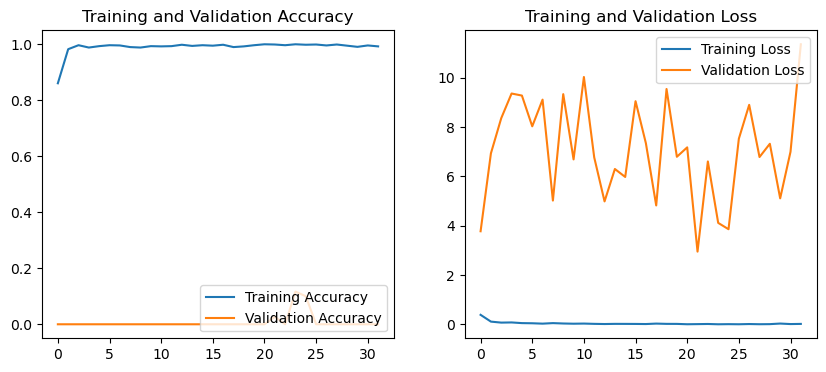

In [394]:
result_plot(result)

validation 데이터를 제대로 예측하지 못하는 것으로 나온다. 원인은 아마도 부족한 데이터 및 해상도(28 x 28)로 보인다.

## 5.3. 얼마나 잘 만들었는지 확인하기

마지막으로 test 데이터에 대한 예측 및 평가를 진행해보자.

In [395]:
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=2)
print(f"test_loss: {test_loss:.3f}")
print(f"test_accuracy: {test_accuracy * 100:.2f}%")

19/19 - 0s - loss: 0.7029 - accuracy: 0.6750 - 180ms/epoch - 9ms/step
test_loss: 0.703
test_accuracy: 67.50%


그 결과 정확도가 67.50%이 되었다.

In [396]:
test_pred_score = model.predict(test_X)
test_pred = np.argmax(test_pred_score, axis=1)

print(test_pred)
print(test_y)

19/19 [==============================] - 0s 5ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

Category:  2


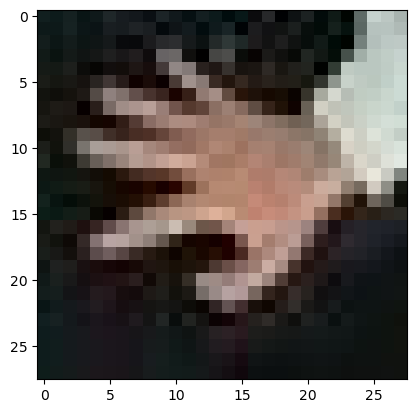

Category:  2


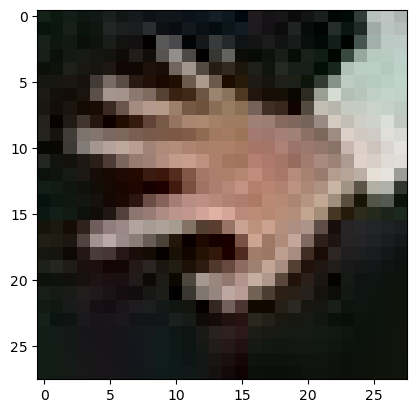

Category:  2


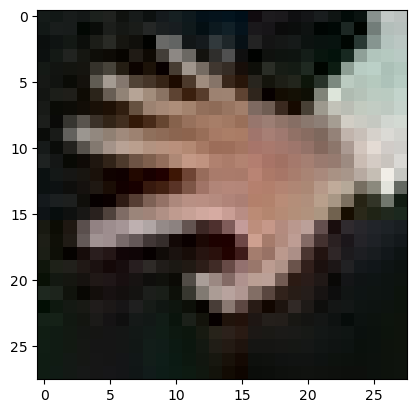

Category:  2


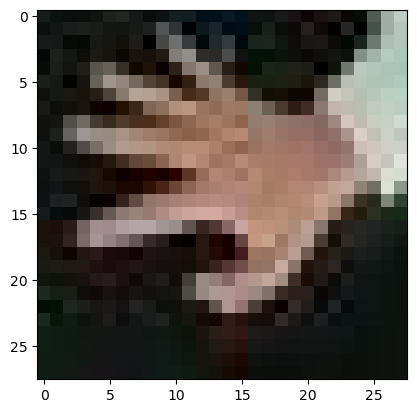

Category:  2


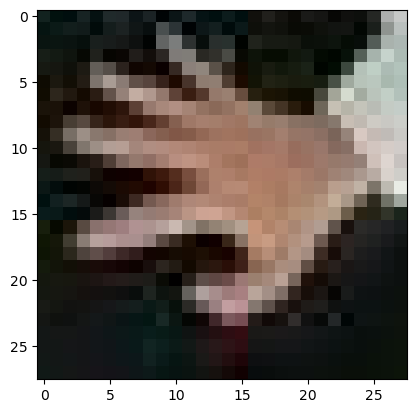

Category:  2


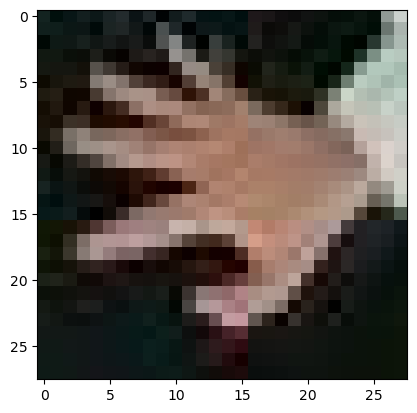

Category:  2


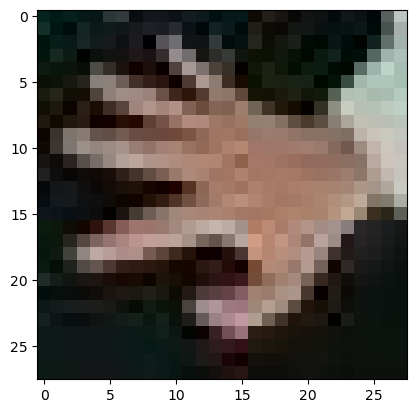

Category:  2


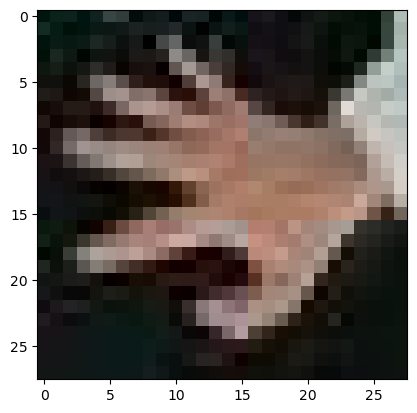

Category:  2


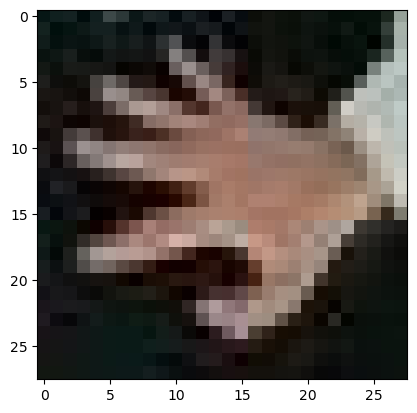

Category:  2


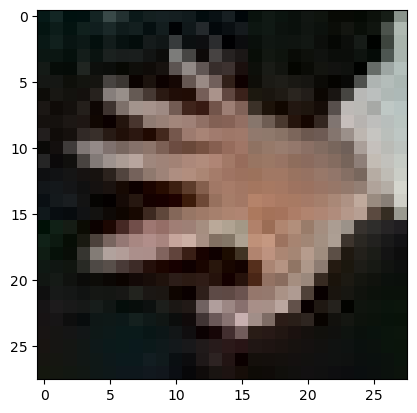

In [397]:
for i in np.where(test_pred != test_y)[0][:10]:
    plt.imshow(test_X[i])
    print('Category: ', test_pred[i])
    plt.show()

같은 사진인 것 같지만 다 다른 사진이다. 데이터의 다양성이 무너진 것 같다.

# 6. 회고하기

## 6.1. 이번 프로젝트에서 어려웠던 점

tensorflow 라이브러리를 어떻게든 가상환경없이 쓰기 위해 채널을 conda-forge로 바꿔 설치하거나  
powershell이 아닌 주피터 터미널에서 설치해 보는 등 설치할 때마다 4시간 이상씩 걸리는 짓을 했지 결국 포기했다.  
아나콘다도 재설치 해보다가 cmd 창이 안열리는 버그가 생겼는데 아마 설치할 때 자동으로 경로를 설정하는 옵션을 체크해서 그런 것 같다.  
이 버그를 해결했지만 base가 기본 커널로 자동으로 설정이 안되는 버그가 또 생겼다.  
찝찝해서 윈도우도 포맷을 했는데 포맷한 김에 이번에 나온 윈도우 11 22H2로 새로 깔았다.

가상환경을 만들고 나니 설치하는데 4시간 걸리던 tensorflow가 이미 설치되어 있단다.  
근데 또 가상환경에서는 주피터 노트북을 열기 위한 명령어 입력이 필요해서 시간이 또 소요됐다.

## 6.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

모델에 다양한 퍼래머더를 넣어봤지만 사실 어떻게 작동하는지는 모른 채로 오직 정확도만 높이는데 초점을 맞췄다.  
통계학과 수업을 들을 때는 이론에 초점이 맞춰져 있어서 항상 정당한 분석만을 수행해 왔었기 때문에  
데이터 분석과의 괴리감이 좀 컸다. 하지만 그래도 통계보단 데이터 과학이 재밌긴 하다.

## 6.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트는 정확도 편차가 매우 컸었다. 싹다 0으로 혹은 1로 혹은 2로 예측해서 정확도가 33%가 나올 때가 있는가 하면  
87%의 정확도가 나올 때도 있었다. 하나의 category만으로 예측하는 문제를 해결하기 위해 이론적으로 필요해 보이는  
BatchNormalization 층을 추가했고, 원인이 오버피팅인지는 모르겠지만 오버피팅을 피하기 위해 Dropout 층도 추가했다.  
하지만 여전히 단일 카테고리 예측 문제는 해결되지 않았다. 그 이유는 아마도 가장 크게는 작은 해상도(28 x 28),  
그 다음으로는 부족한 데이터일 것이다.  
해상도를 28 x 28로 고정하고 학습을 진행하라는 줄 알았지만 다른 그루들을 보니 꼭 그런 건 아닌 것 같았다.  
하지만 회고를 쓰고 있는 지금에 와서 다시 싹 갈아엎고 싶지는 않았다.

## 6.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

이번 루브릭 평가 지표는 사실 모델을 여러번 학습시키다 보면 운이 조금만 좋아도 넘을 수 있었다.  
점수를 넘기지 못한 분들에게는 더 많은 데이터, 더 높은 해상도, 더 다양한 사진(너무 비슷한 사진은 제거)을 추천하고 싶다.

## 6.5. 회상 혹은 자기 다짐

이번에 tensorflow를 가상환경을 안쓰겠다고 오기를 부려서 무려 하루를 날렸었다.  
이제부터는 해당 라이브러리가 가상환경이 필요한지를 체크해서 설치하는데 4시간이나 걸리는 뻘 짓은 하지 말아야겠다.  
그래도 이번 가위바위보 프로젝트는 꽤 재밌던 프로젝트였다. 처음으로 tensorflow 딥러닝을 배워서 그런 것 같다.  
곧 DeepML 플립스쿨에서 딥러닝에 대한 이론을 배우는데 기대가 된다.

# +. Reference

https://dacon.io/competitions/official/235946/codeshare/5929